# Generalized Additive Model

The following is a brief illustrative example of how generalized additive models (GAMs) can be implemented in `delicatessen`. For demonstration, we use data on motorcycle impacts from Silverman (1985). 

Code by Paul Zivich

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import delicatessen as deli
from delicatessen import MEstimator
from delicatessen.estimating_equations import (ee_regression, 
                                               ee_ridge_regression, 
                                               ee_additive_regression)
from delicatessen.utilities import additive_design_matrix, regression_predictions

%matplotlib inline
mpl.rcParams['figure.dpi']= 200
np.random.seed(202301)

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Matplotlib version:  ", mpl.__version__)
print("Delicatessen version:", deli.__version__)

NumPy version:        1.25.2
SciPy version:        1.11.2
Pandas version:       1.4.1
Matplotlib version:   3.5.1
Delicatessen version: 1.4


Loading the motorcycle data (the data can be found in a few different R libraries and other online resources about GAMs). 

In [2]:
# Loading data
d = pd.read_csv("data/silverman.csv")
d['intercept'] = 1

# Formating data for delicatessen
X = np.asarray(d[['intercept', 'times']])
y = np.asarray(d['accel'])

# Formating data for plots
p = pd.DataFrame()
p['times'] = np.linspace(np.min(d['times']), np.max(d['times']), 200)
p['intercept'] = 1
Xp = np.asarray(p[['intercept', 'times']])

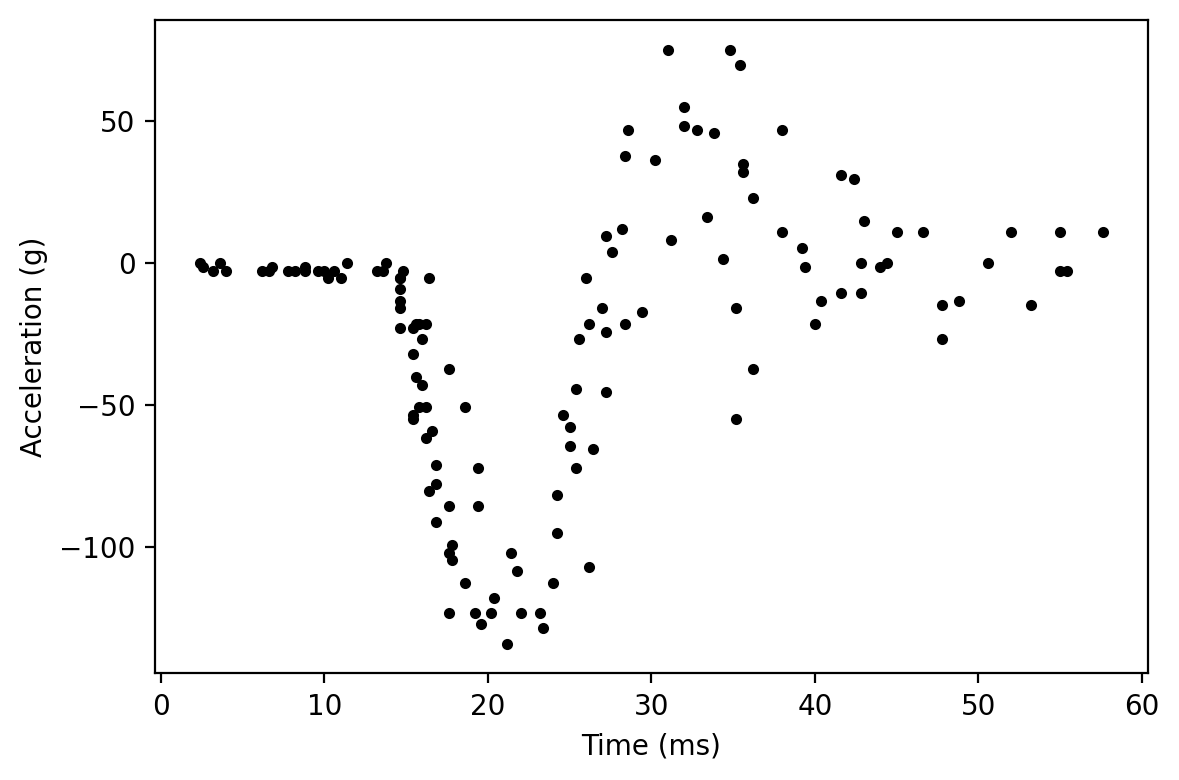

In [3]:
plt.plot(d['times'], d['accel'], '.', color='k')
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration (g)")
plt.tight_layout()

As easily seen in the scatterplot, the relationship between time and acceleration is non-linear. We can show this even further by fitting a regression model with a linear relationship between the variables. We will do that here

In [4]:
def psi(theta):
    return ee_regression(theta=theta, X=X, y=y, model='linear')

In [5]:
estr = MEstimator(psi, init=[0, 0])
estr.estimate(solver='lm')

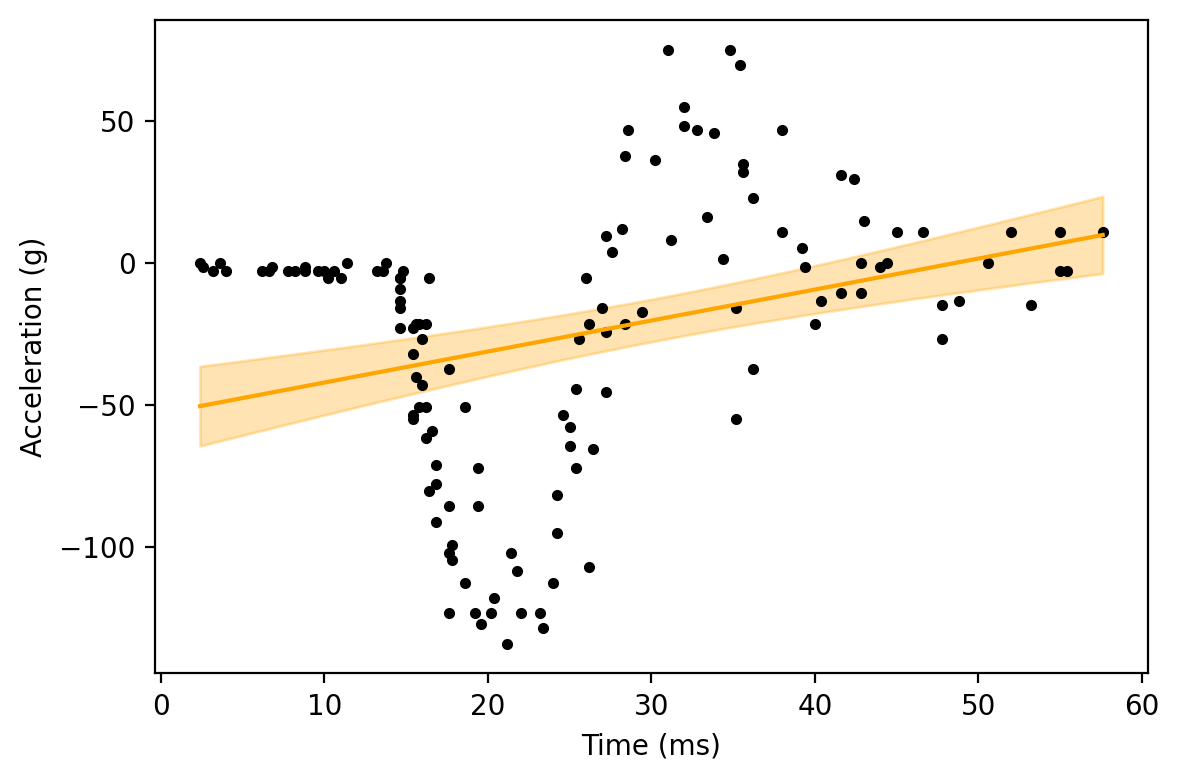

In [6]:
# Predicted values and confidence intervals for plot
pred_y = regression_predictions(Xp, estr.theta, estr.variance)

# Plot
plt.plot(d['times'], d['accel'], '.', color='k')
plt.plot(p['times'], pred_y[:, 0], color='orange')
plt.fill_between(p['times'],
                 pred_y[:, 2], pred_y[:, 3],
                 color='orange', alpha=0.3)
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration (g)")
plt.tight_layout()

## Implementing a GAM

As of v1.1, `delicatessen` has a built-in functionality for GAMs. We will use that built-in functionality here. GAMs are implemented through the use of $L_2$-penalized splines. For implementation, the user needs to provide the knots (number or locations). Other optional arguments include the power of the splines, whether to restrict, and the strength of the penalty.

First, we define our estimating equations. The ``ee_additive_regression`` model builds the additive model design matrix for us, so we only need to pass the design matrix for the linear model above. However, we also need to specify some spline options. For the intercept term, we do not want any splines. For times, we will specify use of 12 knots and a rather strong penalty of 2000. This penalty will prevent the GAM from being too 'wiggly'.

In [7]:
# Defining specifications for splines to built the additive design matrix
knot_locs = np.percentile(d['times'], q=np.linspace(2.5, 97.5, 11)).tolist()
specs = [None,                                               # Spec for 1st term (intercept)
         {"knots": knot_locs, "penalty": 2000, "power": 3}]  # Spec for 2nd term (times)

# Defining the estimating equation
def psi(theta):
    return ee_additive_regression(theta=theta, 
                                  X=X, y=y, 
                                  model='linear',
                                  specifications=specs)

In [8]:
estr = MEstimator(psi, init=[0, 0, ] + [0, ]*10)
estr.estimate(solver='lm', maxiter=2000)

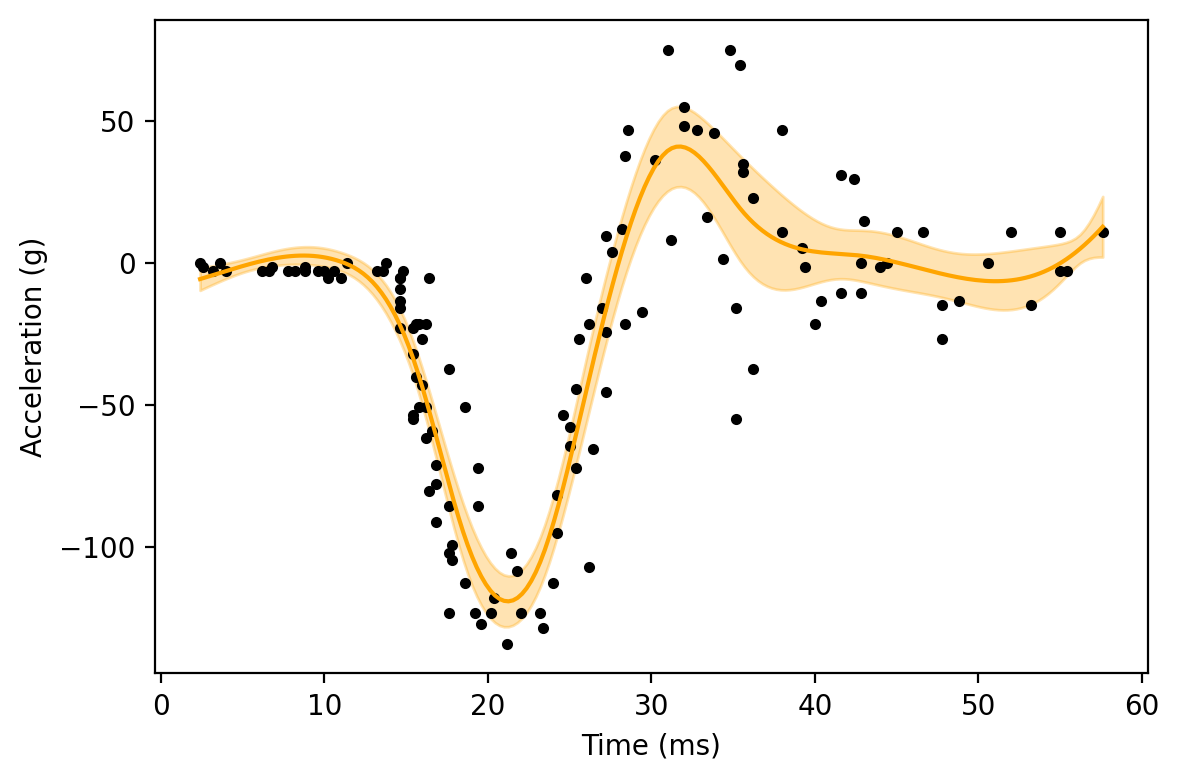

In [9]:
# Creating the corresponding additive design matrix
Xpa = additive_design_matrix(p[['intercept', 'times']],
                            specifications=specs)

# Generating predicted values
pred_y = regression_predictions(Xpa, estr.theta, estr.variance)

# Plot
plt.plot(d['times'], d['accel'], '.', color='k')
plt.plot(p['times'], pred_y[:, 0], color='orange')
plt.fill_between(p['times'],
                 pred_y[:, 2], pred_y[:, 3],
                 color='orange', alpha=0.3)
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration (g)")
plt.tight_layout()

Here, we can see that the GAM does a much better job of following the shape of the scatterplot.

## Impact of the Penalty
To show how the penalty impacts the wiggliness of the GAM, let's increase the GAM penalty by a large amount. As this penalty is only applied to the spline terms, we would expect to see the regression line become smoother. 

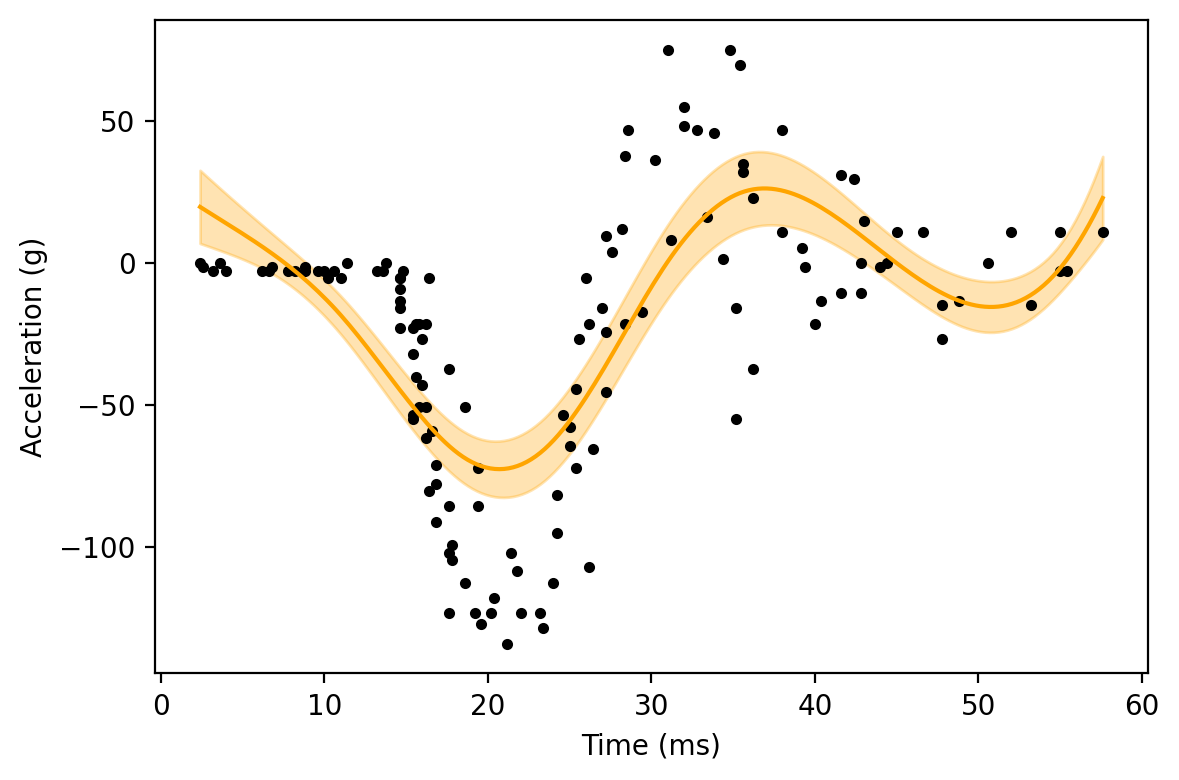

In [10]:
# Defining specifications for splines to built the additive design matrix
knot_locs = np.percentile(d['times'], q=np.linspace(2.5, 97.5, 11)).tolist()
specs = [None,                                               # Spec for 1st term (intercept)
         {"knots": knot_locs, "penalty": 1000000, "power": 3}]  # Spec for 2nd term (times)

# Defining the estimating equation
def psi(theta):
    return ee_additive_regression(theta=theta, 
                                  X=X, y=y, 
                                  model='linear',
                                  specifications=specs)

estr = MEstimator(psi, init=[0, 0, ] + [0, ]*10)
estr.estimate(solver='lm', maxiter=2000)

# Creating the corresponding additive design matrix
Xpa = additive_design_matrix(p[['intercept', 'times']],
                            specifications=specs)

# Generating predicted values
pred_y = regression_predictions(Xpa, estr.theta, estr.variance)

# Plot
plt.plot(d['times'], d['accel'], '.', color='k')
plt.plot(p['times'], pred_y[:, 0], color='orange')
plt.fill_between(p['times'],
                 pred_y[:, 2], pred_y[:, 3],
                 color='orange', alpha=0.3)
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration (g)")
plt.tight_layout()

Here, we can see the estimated function from the GAM is smoother than the previous GAM. To continue along this trend, let's crank up the penalty further.

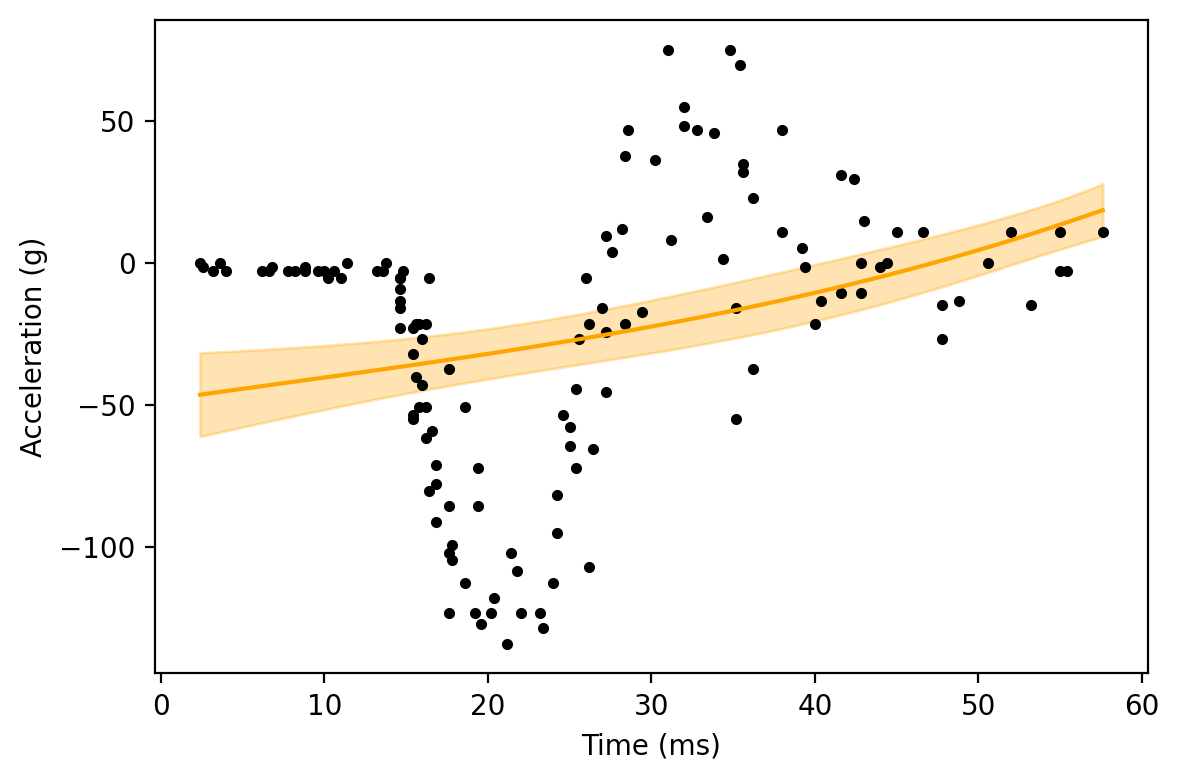

In [11]:
# Defining specifications for splines to built the additive design matrix
knot_locs = np.percentile(d['times'], q=np.linspace(2.5, 97.5, 11)).tolist()
specs = [None,                                               # Spec for 1st term (intercept)
         {"knots": knot_locs, "penalty": 1e11, "power": 3}]  # Spec for 2nd term (times)

# Defining the estimating equation
def psi(theta):
    return ee_additive_regression(theta=theta, 
                                  X=X, y=y, 
                                  model='linear',
                                  specifications=specs)

estr = MEstimator(psi, init=[0, 0, ] + [0, ]*10)
estr.estimate(solver='lm', maxiter=2000)

# Creating the corresponding additive design matrix
Xpa = additive_design_matrix(p[['intercept', 'times']],
                            specifications=specs)

# Generating predicted values
pred_y = regression_predictions(Xpa, estr.theta, estr.variance)

# Plot
plt.plot(d['times'], d['accel'], '.', color='k')
plt.plot(p['times'], pred_y[:, 0], color='orange')
plt.fill_between(p['times'],
                 pred_y[:, 2], pred_y[:, 3],
                 color='orange', alpha=0.3)
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration (g)")
plt.tight_layout()

Here, the GAM is very similar to the linear regression we started with. This helps to show the more general relationship: as the penalty goes to infinity, the GAM will coincide with the linear model from before. 

To summarize, we want a penalty that prevents overfitting to the data but does not prevent the GAM from approximating the data. This selection of penalization is commonly done via cross-validation. However, use of cross-validation invalidates the variance estimation (including with the sandwich variance estimator). Therefore, I would recommend sacrificing the optimal penalty parameter (as determined by cross-validation) in favor of variance estimation with `delicatessen`.

## GAM by-hand
GAMs can also be done by-hand with `delicatessen`. This allows for flexibility in specifications beyond the `ee_additive_regression` options or use with other models. Here, we will reapply the GAM from before.

First, we will use the ``additive_design_matrix`` function to generate the corresponding design matrix with splines. We will also have the penalty returned into the `penalty` object. 

In [12]:
# Setting up the design matrix
knot_locs = np.percentile(d['times'], q=np.linspace(2.5, 97.5, 11)).tolist()
specs = [None,                                               # Spec for 1st term (intercept)
         {"knots": knot_locs, "penalty": 2e3, "power": 3}]  # Spec for 2nd term (times)
Xa, penalty = additive_design_matrix(d[['intercept', 'times']],
                                     specifications=specs,
                                     return_penalty=True)
penalty

[0,
 0,
 2000.0,
 2000.0,
 2000.0,
 2000.0,
 2000.0,
 2000.0,
 2000.0,
 2000.0,
 2000.0,
 2000.0]

While the penalty could be specified by-hand, the `additive_design_matrix` also makes it easy to get the penalty. To show the advantage of by-hand implementations, we will adjust the penalty for the later spline terms. Specifically, we will apply a stronger penalty

In [13]:
for i in [7, 8, 9, 10, 11]:
    penalty[i] = 50000.
    
penalty

[0,
 0,
 2000.0,
 2000.0,
 2000.0,
 2000.0,
 2000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0]

To implement the GAM, we will now use the built-in estimating equation for Ridge regression. This is the same penalization scheme used by the built-in GAM

In [14]:
def psi(theta):
    return ee_ridge_regression(theta=theta,
                               X=Xa, y=y, model='linear',
                               penalty=penalty)

In [15]:
estr = MEstimator(psi, init=[0, 0, ] + [0, ]*10)
estr.estimate(solver='lm', maxiter=2000)

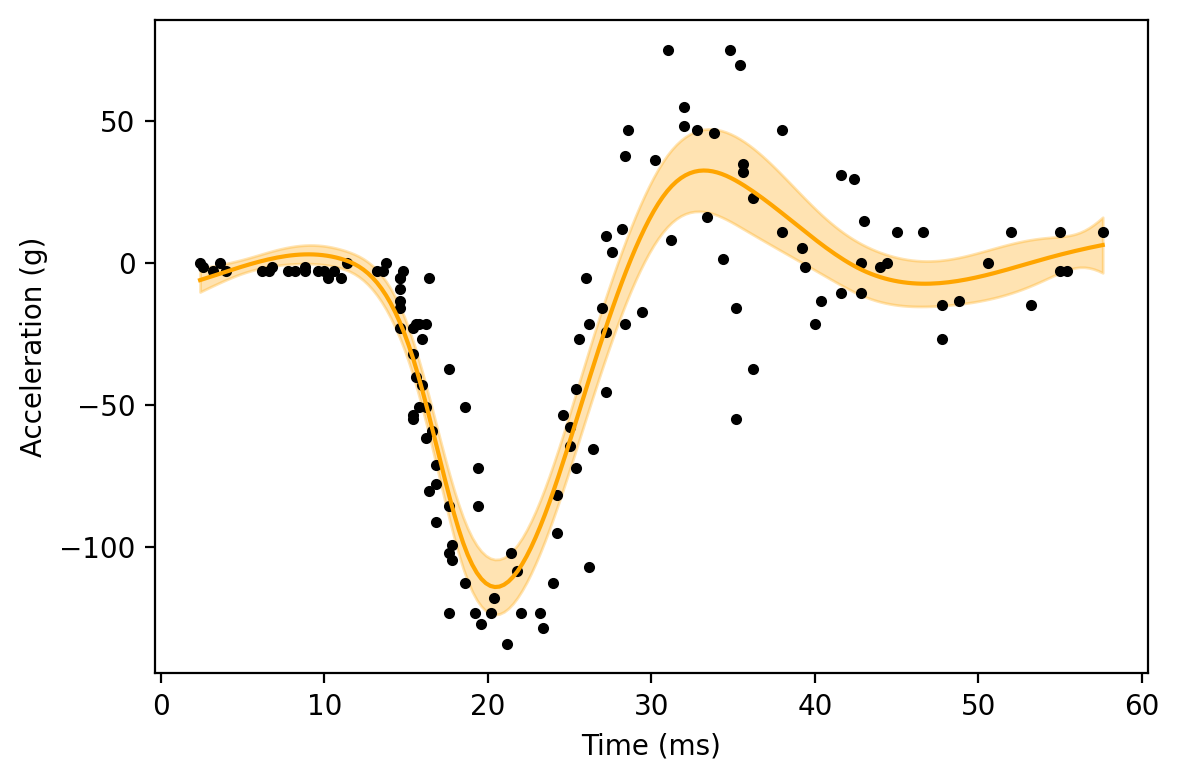

In [16]:
# Creating the corresponding additive design matrix
Xpa = additive_design_matrix(p[['intercept', 'times']],
                            specifications=specs)

# Generating predicted values
pred_y = regression_predictions(Xpa, estr.theta, estr.variance)

# Plot
plt.plot(d['times'], d['accel'], '.', color='k')
plt.plot(p['times'], pred_y[:, 0], color='orange')
plt.fill_between(p['times'],
                 pred_y[:, 2], pred_y[:, 3],
                 color='orange', alpha=0.3)
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration (g)")
plt.tight_layout()

Here, the end of the function (time > 40) is smoother than the first GAM but still allows for flexibility at the start. This provides a simple illustration of how GAMs can be implemented by-hand using custom penalities.

## Conclusions

GAMs are a flexible method that place fewer constraints on the functional forms of relationships via splines. These splines don't require us to know the true underlying functional form. Instead, the higher-order splines (with well-chosen knots) can serve as close approximations. To implement GAMs, `delicatessen` can easily implemented with a built-in functionality or by-hand using built-in pre-processing functions.

### References

Silverman BW. (1985). Some aspects of the spline smoothing approach to non‐parametric regression curve fitting. *Journal of the Royal Statistical Society: Series B (Methodological)*, 47(1), 1-21.